# Multi-Platform LLM Deployment & Performance Comparison

This notebook deploys the Qwen2.5-3B model across multiple platforms and compares their performance:

## Deployment Targets:
1. **AKS with T4 GPU** (Spot VM) 
2. **AKS CPU-only** - No GPU required 
3. **Azure Container Apps** - Serverless GPU deployment

## Performance Metrics Measured:
- **Tokens per Second (TPS)** - Throughput performance
- **Time to First Token (TTFT)** - Initial response latency
- **End-to-End Latency** - Total inference time

**Note:** For cold start performance testing with artifact streaming, see the separate notebook: `aca-cold-start-artifact-streaming.ipynb`

In [18]:
import subprocess
import time
import json
import os
from datetime import datetime
import statistics

# Configuration
RESOURCE_GROUP = "gpu-deployments-rg"
LOCATION = "swedencentral"
CLUSTER_NAME = "kaito-playground-cluster"
MODEL_NAME = "Qwen/Qwen2.5-3B"

# Deployment flags - Set to True to enable
DEPLOY_T4 = True        # T4 GPU (Default, Spot VM)
DEPLOY_A10 = True      # A10 GPU 
DEPLOY_CPU = True       # CPU-only
DEPLOY_ACA = True       # Azure Container Apps

# Node pool configs
DEPLOYMENTS = {
    "t4": {
        "enabled": DEPLOY_T4,
        "nodepool_name": "gput4",
        "vm_size": "Standard_NC4as_T4_v3",
        "workspace_name": "ws-qwen-t4",
        "gpu_count": 1,
        "use_spot": True,
        "torch_dtype": "float16"
    },
    "a10": {
        "enabled": DEPLOY_A10,
        "nodepool_name": "gpua10",
        "vm_size": "Standard_NV36ads_A10_v5",
        "workspace_name": "ws-qwen-a10",
        "gpu_count": 1,
        "use_spot": True,
        "torch_dtype": "float16"
    },
    "cpu": {
        "enabled": DEPLOY_CPU,
        "nodepool_name": "cpuonly",
        "vm_size": "Standard_D8as_v5",
        "workspace_name": "ws-qwen-cpu",
        "gpu_count": 0,
        "use_spot": False,
        "torch_dtype": "float16"
    }
}

# ACA config - Deploy to both T4 and A100
ACA_DEPLOYMENTS = {
    "aca-t4": {
        "enabled": DEPLOY_ACA,
        "env_name": "kaito-aca-env",
        "app_name": "qwen-aca-t4",
        "workload_profile": "gpu-t4",
        "workload_type": "Consumption-GPU-NC8as-T4",
        "gpu_type": "T4"
    },
    "aca-a100": {
        "enabled": DEPLOY_ACA,
        "env_name": "kaito-aca-env",
        "app_name": "qwen-aca-a100",
        "workload_profile": "gpu-a100",
        "workload_type": "Consumption-GPU-NC24-A100",
        "gpu_type": "A100"
    }
}

# Test prompts for benchmarking
TEST_PROMPTS = [
    "Explain quantum computing in simple terms.",
    "Write a short story about a robot learning to paint.",
    "What are the key principles of sustainable architecture?"
]

print("Configuration loaded:")
print(f"  Resource Group: {RESOURCE_GROUP}")
print(f"  Location: {LOCATION}")
print(f"  Model: {MODEL_NAME}")
print(f"\nActive Deployments:")
for name, config in DEPLOYMENTS.items():
    if config['enabled']:
        print(f"  ✅ {name.upper()}: {config['vm_size']}")
for name, config in ACA_DEPLOYMENTS.items():
    if config['enabled']:
        print(f"  ✅ {name.upper()}: {config['workload_type']} ({config['gpu_type']} GPU)")

print("\n📦 Installing tiktoken for accurate token counting...")
import subprocess
result = subprocess.run(
    ["pip", "install", "-q", "tiktoken"],
    capture_output=True,
    text=True
)


Configuration loaded:
  Resource Group: gpu-deployments-rg
  Location: swedencentral
  Model: Qwen/Qwen2.5-3B

Active Deployments:
  ✅ T4: Standard_NC4as_T4_v3
  ✅ A10: Standard_NV36ads_A10_v5
  ✅ CPU: Standard_D8as_v5
  ✅ ACA-T4: Consumption-GPU-NC8as-T4 (T4 GPU)
  ✅ ACA-A100: Consumption-GPU-NC24-A100 (A100 GPU)

📦 Installing tiktoken for accurate token counting...


In [19]:
def run_command(cmd, description="", check=True, capture_output=True, silent=False):
    """Run a shell command and return the result"""
    if description and not silent:
        print(f"\n{'='*60}")
        print(f"📋 {description}")
        print(f"{'='*60}")
    
    if not silent:
        print(f"Running: {cmd[:100]}{'...' if len(cmd) > 100 else ''}")
    
    result = subprocess.run(
        cmd,
        shell=True,
        capture_output=capture_output,
        text=True,
        check=False
    )
    
    if result.returncode != 0 and check:
        print(f"❌ Error: {result.stderr}")
        raise Exception(f"Command failed: {cmd}")
    
    if capture_output and result.stdout and not silent:
        print(result.stdout)
    
    return result

def wait_with_progress(seconds, message="Waiting"):
    """Wait with a progress indicator"""
    print(f"\n{message}...", end="", flush=True)
    for i in range(seconds):
        time.sleep(1)
        if i % 5 == 0:
            print(".", end="", flush=True)
    print(" Done!")

def count_tokens(text):
    """Count actual tokens in text using tiktoken"""
    import tiktoken
    encoding = tiktoken.get_encoding("cl100k_base")
    tokens = encoding.encode(text)
    return len(tokens)

print("✅ Helper functions defined")

✅ Helper functions defined


## Part 1: Azure Kubernetes Service (AKS) Deployments

### Step 1: Create Resource Group and AKS Cluster

In [ ]:
# Create resource group
run_command(
    f"az group create --name {RESOURCE_GROUP} --location {LOCATION}",
    "Creating Resource Group"
)

# Create AKS cluster with KAITO
run_command(
    f"""az aks create \
        --location {LOCATION} \
        --resource-group {RESOURCE_GROUP} \
        --name {CLUSTER_NAME} \
        --enable-ai-toolchain-operator \
        --enable-oidc-issuer \
        --node-count 3 \
        --generate-ssh-keys""",
    "Creating AKS Cluster with KAITO (5-7 minutes)"
)

# Get credentials
run_command(
    f"az aks get-credentials --resource-group {RESOURCE_GROUP} --name {CLUSTER_NAME} --overwrite-existing",
    "Getting cluster credentials"
)

run_command("kubectl get nodes", "Verifying cluster")

### Step 2: Create GPU/CPU Node Pools

In [ ]:
for deploy_name, config in DEPLOYMENTS.items():
    if not config['enabled']:
        continue
    
    print(f"\n{'='*70}")
    print(f"Creating node pool: {deploy_name.upper()} - {config['vm_size']}")
    print(f"{'='*70}")
    
    # Check if node pool already exists
    check_result = run_command(
        f"az aks nodepool show --resource-group {RESOURCE_GROUP} --cluster-name {CLUSTER_NAME} --name {config['nodepool_name']}",
        "",
        check=False,
        capture_output=True,
        silent=True
    )
    
    if check_result.returncode == 0:
        print(f"ℹ️  Node pool {config['nodepool_name']} already exists, skipping creation")
    else:
        # Build the command
        cmd = f"""az aks nodepool add \
            --resource-group {RESOURCE_GROUP} \
            --cluster-name {CLUSTER_NAME} \
            --name {config['nodepool_name']} \
            --node-count 1 \
            --node-vm-size {config['vm_size']} \
            --labels apps=llm-{deploy_name} deployment={deploy_name}"""
        
        # Add GPU-specific labels and taints
        if config['gpu_count'] > 0:
            cmd += " sku=gpu"
            cmd += " --node-taints sku=gpu:NoSchedule"
        
        # Add Spot VM configuration
        if config['use_spot']:
            cmd += """ \
            --priority Spot \
            --spot-max-price -1 \
            --eviction-policy Delete"""
        
        # Add zones (A10 Standard_NV36ads_A10_v5 has NotAvailableForSubscription restrictions in zones for swedencentral)
        if deploy_name != "a10":
            cmd += " --zones 2 3"
        
        run_command(cmd, f"Creating {deploy_name.upper()} node pool")
    
    # Wait for node to be ready
    print(f"\n⏳ Waiting for {deploy_name.upper()} node to be ready...")
    run_command(
        f"kubectl wait --for=condition=Ready node -l agentpool={config['nodepool_name']} --timeout=10m",
        f"Waiting for {deploy_name.upper()} node"
    )

print("\n✅ All enabled node pools created!")

### Step 3: Patch NVIDIA Device Plugin for Spot Nodes

In [25]:
# Check if any GPU deployments are enabled
gpu_enabled = any(config['enabled'] and config['gpu_count'] > 0 for config in DEPLOYMENTS.values())

if gpu_enabled:
    print("Creating dedicated NVIDIA device plugin for GPU Spot nodes...")
    wait_with_progress(30, "Waiting for KAITO to initialize")
    
    # Create a dedicated DaemonSet for GPU nodes with proper tolerations
    nvidia_ds_yaml = '''apiVersion: apps/v1
kind: DaemonSet
metadata:
  name: nvidia-device-plugin-gpu-spot
  namespace: kube-system
  labels:
    k8s-app: nvidia-device-plugin-gpu-spot
spec:
  selector:
    matchLabels:
      name: nvidia-device-plugin-gpu-spot
  updateStrategy:
    type: RollingUpdate
  template:
    metadata:
      labels:
        name: nvidia-device-plugin-gpu-spot
    spec:
      tolerations:
      - key: sku
        operator: Equal
        value: gpu
        effect: NoSchedule
      - key: kubernetes.azure.com/scalesetpriority
        operator: Equal
        value: spot
        effect: NoSchedule
      - key: CriticalAddonsOnly
        operator: Exists
      - effect: NoSchedule
        operator: Exists
      nodeSelector:
        sku: gpu
      priorityClassName: system-node-critical
      containers:
      - image: mcr.microsoft.com/oss/v2/nvidia/k8s-device-plugin:v0.17.0
        name: nvidia-device-plugin-ctr
        args:
          - "--fail-on-init-error=false"
          - "--pass-device-specs=true"
        securityContext:
          allowPrivilegeEscalation: false
          capabilities:
            drop: ["ALL"]
        volumeMounts:
        - name: device-plugin
          mountPath: /var/lib/kubelet/device-plugins
      volumes:
      - name: device-plugin
        hostPath:
          path: /var/lib/kubelet/device-plugins
'''
    
    with open('/tmp/nvidia-device-plugin-gpu-spot.yaml', 'w') as f:
        f.write(nvidia_ds_yaml)
    
    # Delete if exists
    run_command(
        "kubectl delete daemonset nvidia-device-plugin-gpu-spot -n kube-system",
        "Removing old GPU Spot device plugin if exists",
        check=False,
        silent=True
    )
    
    wait_with_progress(5, "Waiting for cleanup")
    
    # Apply the new DaemonSet
    run_command(
        "kubectl apply -f /tmp/nvidia-device-plugin-gpu-spot.yaml",
        "Creating GPU Spot NVIDIA device plugin DaemonSet"
    )
    
    # Wait for the pods to be ready
    print("\nWaiting for NVIDIA device plugin pods to start...")
    wait_with_progress(30, "Waiting for pods")
    
    # Check status
    result = run_command(
        "kubectl get pods -n kube-system -l name=nvidia-device-plugin-gpu-spot -o wide",
        "Checking NVIDIA device plugin status",
        capture_output=True,
        check=False
    )
    
    if result.returncode == 0:
        print("\n" + result.stdout)
        
        # Verify GPU allocation
        print("\nVerifying GPU resources on nodes:")
        run_command(
            "kubectl get nodes -l sku=gpu -o custom-columns=NAME:.metadata.name,GPUs:.status.allocatable.'nvidia\\.com/gpu'",
            "",
            check=False
        )
        
        if "Running" in result.stdout:
            print("\n✅ NVIDIA device plugin deployed and running on GPU nodes")
        else:
            print("\n⚠️  NVIDIA device plugin deployed but pods may still be starting")
    else:
        print("\n⚠️  Could not verify device plugin status")
else:
    print("ℹ️  No GPU deployments enabled, skipping NVIDIA plugin deployment")

Creating dedicated NVIDIA device plugin for GPU Spot nodes...

Waiting for KAITO to initialize......... Done!

Waiting for cleanup.... Done!

📋 Creating GPU Spot NVIDIA device plugin DaemonSet
Running: kubectl apply -f /tmp/nvidia-device-plugin-gpu-spot.yaml
daemonset.apps/nvidia-device-plugin-gpu-spot created


Waiting for NVIDIA device plugin pods to start...

Waiting for pods......... Done!

📋 Checking NVIDIA device plugin status
Running: kubectl get pods -n kube-system -l name=nvidia-device-plugin-gpu-spot -o wide
NAME                                  READY   STATUS    RESTARTS   AGE   IP             NODE                             NOMINATED NODE   READINESS GATES
nvidia-device-plugin-gpu-spot-ssh49   1/1     Running   0          30s   10.244.3.152   aks-gput4-29289539-vmss000000    <none>           <none>
nvidia-device-plugin-gpu-spot-zs9ft   1/1     Running   0          30s   10.244.4.45    aks-gpua10-41044266-vmss000000   <none>           <none>


NAME                          

### Step 4: Deploy KAITO Workspaces for Each Configuration

In [26]:
def create_workspace_yaml(deploy_name, config):
    """Generate KAITO workspace YAML"""
    
    # Base tolerations
    tolerations = []
    
    if config['gpu_count'] > 0:
        tolerations.extend([
            {"key": "sku", "operator": "Equal", "value": "gpu", "effect": "NoSchedule"}
        ])
    
    if config['use_spot']:
        tolerations.append(
            {"key": "kubernetes.azure.com/scalesetpriority", "operator": "Equal", "value": "spot", "effect": "NoSchedule"}
        )
    
    tolerations_yaml = "\n".join([
        f"        - key: {t['key']}\n          operator: {t['operator']}\n          " + 
        (f"value: {t['value']}\n          " if 'value' in t else "") + 
        f"effect: {t['effect']}"
        for t in tolerations
    ])
    
    gpu_request = f"nvidia.com/gpu: {config['gpu_count']}" if config['gpu_count'] > 0 else "cpu: \"4\""
    
    workspace_yaml = f'''apiVersion: kaito.sh/v1beta1
kind: Workspace
metadata:
  name: {config['workspace_name']}
resource:
  instanceType: "{config['vm_size']}"
  count: 1
  labelSelector:
    matchLabels:
      apps: llm-{deploy_name}
      deployment: {deploy_name}
inference:
  template:
    spec:
      containers:
        - name: inference-container
          image: mcr.microsoft.com/aks/kaito/kaito-base:0.0.8
          command: ["accelerate"]
          args:
            - "launch"
            - "--num_processes"
            - "1"
            - "--num_machines"
            - "1"
            - "--gpu_ids"
            - "all"
            - "tfs/inference_api.py"
            - "--pipeline"
            - "text-generation"
            - "--trust_remote_code"
            - "--allow_remote_files"
            - "--pretrained_model_name_or_path"
            - "{MODEL_NAME}"
            - "--torch_dtype"
            - "{config['torch_dtype']}"
          resources:
            requests:
              {gpu_request}
              memory: "8Gi"
            limits:
              {gpu_request}
              memory: "8Gi"
          livenessProbe:
            httpGet:
              path: /health
              port: 5000
            initialDelaySeconds: 600
            periodSeconds: 10
            timeoutSeconds: 1
            failureThreshold: 3
          readinessProbe:
            httpGet:
              path: /health
              port: 5000
            initialDelaySeconds: 30
            periodSeconds: 10
            timeoutSeconds: 1
            failureThreshold: 3
          volumeMounts:
            - name: dshm
              mountPath: /dev/shm
      volumes:
        - name: dshm
          emptyDir:
            medium: Memory
      tolerations:
{tolerations_yaml}
'''
    return workspace_yaml

# Deploy workspaces
for deploy_name, config in DEPLOYMENTS.items():
    if not config['enabled']:
        continue
    
    print(f"\n{'='*70}")
    print(f"Deploying workspace: {config['workspace_name']}")
    print(f"{'='*70}")
    
    yaml_content = create_workspace_yaml(deploy_name, config)
    yaml_file = f"/tmp/workspace-{deploy_name}.yaml"
    
    with open(yaml_file, 'w') as f:
        f.write(yaml_content)
    
    run_command(f"kubectl apply -f {yaml_file}", f"Deploying {deploy_name.upper()} workspace")

print("\n✅ All workspaces deployed! Model download will take 10-15 minutes.")


Deploying workspace: ws-qwen-t4

📋 Deploying T4 workspace
Running: kubectl apply -f /tmp/workspace-t4.yaml
workspace.kaito.sh/ws-qwen-t4 configured


Deploying workspace: ws-qwen-a10

📋 Deploying A10 workspace
Running: kubectl apply -f /tmp/workspace-a10.yaml
workspace.kaito.sh/ws-qwen-a10 created


Deploying workspace: ws-qwen-cpu

📋 Deploying CPU workspace
Running: kubectl apply -f /tmp/workspace-cpu.yaml
workspace.kaito.sh/ws-qwen-cpu unchanged


✅ All workspaces deployed! Model download will take 10-15 minutes.


### Step 5: Monitor AKS Workspace Deployments

In [ ]:
def wait_for_workspace(workspace_name, timeout=1800):
    """Wait for a workspace to be ready"""
    print(f"\nMonitoring {workspace_name}...")
    start_time = time.time()
    
    while time.time() - start_time < timeout:
        result = run_command(
            f"kubectl get workspace {workspace_name} -o json",
            "",
            check=False,
            capture_output=True,
            silent=True
        )
        
        if result.returncode == 0:
            workspace = json.loads(result.stdout)
            conditions = workspace.get('status', {}).get('conditions', [])
            
            for cond in conditions:
                if cond['type'] == 'WorkspaceSucceeded' and cond['status'] == 'True':
                    elapsed = int(time.time() - start_time)
                    print(f"  ✅ {workspace_name} ready in {elapsed}s")
                    return True, elapsed
        
        elapsed = int(time.time() - start_time)
        print(f"\r  ⏳ {workspace_name}: {elapsed}s elapsed...", end="", flush=True)
        time.sleep(30)
    
    print(f"\n  ⚠️  {workspace_name} timeout")
    return False, timeout

# Wait for all enabled workspaces
workspace_ready_times = {}

for deploy_name, config in DEPLOYMENTS.items():
    if config['enabled']:
        success, elapsed = wait_for_workspace(config['workspace_name'])
        workspace_ready_times[deploy_name] = elapsed if success else None

print("\n" + "="*70)
print("AKS Workspace Deployment Summary:")
print("="*70)
for name, elapsed in workspace_ready_times.items():
    if elapsed:
        print(f"  {name.upper()}: ✅ Ready in {elapsed}s ({elapsed//60}m {elapsed%60}s)")
    else:
        print(f"  {name.upper()}: ⚠️  Not ready")

## Part 2: Azure Container Apps Deployment

### Step 6: Deploy to Azure Container Apps

In [ ]:
# Check if any ACA deployment is enabled
aca_enabled = any(config['enabled'] for config in ACA_DEPLOYMENTS.values())

if aca_enabled:
    print("\n" + "="*70)
    print("Deploying to Azure Container Apps")
    print("="*70)
    
    # Get the env_name from first enabled deployment (they all share the same environment)
    env_name = next(config['env_name'] for config in ACA_DEPLOYMENTS.values() if config['enabled'])
    
    # Create Container Apps environment (only once)
    run_command(
        f"""az containerapp env create \
            -n {env_name} \
            -g {RESOURCE_GROUP} \
            -l {LOCATION} \
            --enable-workload-profiles""",
        "Creating Container Apps Environment"
    )
    
    # Add GPU workload profiles for each enabled deployment
    for deploy_name, aca_config in ACA_DEPLOYMENTS.items():
        if not aca_config['enabled']:
            continue
            
        print(f"\n📦 Adding {aca_config['gpu_type']} GPU workload profile...")
        
        # Try to add the workload profile, but continue on error for A100
        result = run_command(
            f"""az containerapp env workload-profile add \
                --name {aca_config['env_name']} \
                --resource-group {RESOURCE_GROUP} \
                --workload-profile-name {aca_config['workload_profile']} \
                --workload-profile-type {aca_config['workload_type']}""",
            f"Adding {aca_config['gpu_type']} GPU Workload Profile",
            check=False
        )
        
        if result.returncode != 0:
            print(f"⚠️  Warning: Could not add {aca_config['gpu_type']} workload profile")
            print(f"   This GPU type may not be available in {LOCATION}")
            print(f"   Disabling {deploy_name} deployment...")
            aca_config['enabled'] = False
    
    # Deploy KAITO base image with Qwen2.5-3B for each enabled ACA deployment
    aca_endpoints = {}
    
    for deploy_name, aca_config in ACA_DEPLOYMENTS.items():
        if not aca_config['enabled']:
            continue
        
        print(f"\n{'='*70}")
        print(f"📦 Deploying {aca_config['gpu_type']} GPU: {aca_config['app_name']}")
        print(f"{'='*70}")
        
        # Step 1: Create basic container app
        run_command(
            f"""az containerapp create \
                -n {aca_config['app_name']} \
                -g {RESOURCE_GROUP} \
                --environment {aca_config['env_name']} \
                --image mcr.microsoft.com/aks/kaito/kaito-base:0.0.8 \
                --cpu 4.0 \
                --memory 8Gi \
                --min-replicas 1 \
                --max-replicas 1 \
                --ingress external \
                --target-port 5000 \
                --workload-profile-name {aca_config['workload_profile']}""",
            f"Creating {aca_config['gpu_type']} Container App (Step 1: Basic deployment)"
        )
        
        # Step 2: Update with command/args using YAML
        print(f"\n🔧 Configuring KAITO inference startup command for {aca_config['gpu_type']}...")
        yaml_config = f"""properties:
  template:
    containers:
    - name: kaito-inference
      image: mcr.microsoft.com/aks/kaito/kaito-base:0.0.8
      command:
      - accelerate
      args:
      - launch
      - --num_processes
      - "1"
      - --num_machines
      - "1"
      - --gpu_ids
      - all
      - tfs/inference_api.py
      - --pipeline
      - text-generation
      - --trust_remote_code
      - --allow_remote_files
      - --pretrained_model_name_or_path
      - {MODEL_NAME}
      - --torch_dtype
      - float16
      resources:
        cpu: 4.0
        memory: 8Gi
"""
        
        yaml_file = f"/tmp/aca-kaito-update-{deploy_name}.yaml"
        with open(yaml_file, 'w') as f:
            f.write(yaml_config)
        
        run_command(
            f"az containerapp update -n {aca_config['app_name']} -g {RESOURCE_GROUP} --yaml {yaml_file}",
            f"Configuring KAITO startup command for {aca_config['gpu_type']} (Step 2: Command/Args update)"
        )
        
        # Get the endpoint
        result = run_command(
            f"""az containerapp show -n {aca_config['app_name']} -g {RESOURCE_GROUP} \
                --query properties.configuration.ingress.fqdn -o tsv""",
            f"Getting {aca_config['gpu_type']} Container App Endpoint",
            capture_output=True
        )
        
        endpoint = result.stdout.strip()
        aca_endpoints[deploy_name] = endpoint
        print(f"\n✅ {aca_config['gpu_type']} ACA deployed at: https://{endpoint}")
        print(f"⏳ Model download will take 10-15 minutes on first request")
    
    print(f"\n{'='*70}")
    print(f"✅ All ACA deployments completed!")
    print(f"{'='*70}")
else:
    print("\nℹ️  Azure Container Apps deployment disabled")
    aca_endpoints = {}

## Part 3: Verify Inference Works

### Step 7: Test Inference on Each Platform

In [28]:
def test_inference_simple(endpoint_name, endpoint_url, endpoint_type):
    """Test that inference actually works and show the output"""
    print(f"\n{'='*70}")
    print(f"Testing {endpoint_name.upper()}")
    print(f"{'='*70}")
    
    test_prompt = "Write a haiku about artificial intelligence."
    print(f"📝 Prompt: '{test_prompt}'")
    
    json_data = json.dumps({"prompt": test_prompt})
    
    if endpoint_type == 'aks':
        # For AKS
        ip = endpoint_url.replace('http://', '').replace('https://', '')
        cmd = f'''kubectl run test-{endpoint_name}-{int(time.time())} --rm -i --restart=Never --image=curlimages/curl -- curl -s -X POST http://{ip}/chat -H "Content-Type: application/json" -d '{json_data}' '''
    else:
        # For ACA
        cmd = f'''curl -s -X POST {endpoint_url}/chat -H "Content-Type: application/json" -d '{json_data}' '''
    
    result = run_command(cmd, "", check=False, capture_output=True, silent=True)
    
    if result.returncode == 0:
        try:
            output = result.stdout.strip()
            # Handle AKS output with "pod deleted" suffix
            if 'pod' in output and 'deleted' in output:
                json_part = output[:output.rfind('}') + 1]
            else:
                json_part = output
            
            response = json.loads(json_part)
            if 'Result' in response:
                generated = response['Result']
                print(f"✅ Success!")
                print(f"🤖 Response: {generated}")
                return True, generated
        except Exception as e:
            print(f"❌ Failed to parse response: {e}")
            return False, None
    
    print(f"❌ Request failed")
    return False, None

# Collect endpoints
print("\n" + "="*70)
print("INFERENCE VERIFICATION")
print("="*70)

endpoints = {}

# AKS endpoints - check both workspace_ready_times and actual workspace status
for deploy_name, config in DEPLOYMENTS.items():
    if not config['enabled']:
        continue
    
    # Check if workspace is actually ready (even if we didn't monitor it)
    workspace_check = run_command(
        f"kubectl get workspace {config['workspace_name']} -o jsonpath='{{.status.conditions[?(@.type==\"WorkspaceSucceeded\")].status}}'",
        "",
        check=False,
        capture_output=True,
        silent=True
    )
    
    is_ready = workspace_check.returncode == 0 and workspace_check.stdout.strip() == "True"
    
    if is_ready or workspace_ready_times.get(deploy_name):
        result = run_command(
            f"kubectl get svc {config['workspace_name']} -o jsonpath='{{.spec.clusterIP}}'",
            "",
            capture_output=True,
            silent=True
        )
        
        if result.returncode == 0 and result.stdout.strip():
            endpoints[deploy_name] = {
                'type': 'aks',
                'url': f"http://{result.stdout.strip()}",
                'config': config
            }

# ACA endpoints
for deploy_name, endpoint in aca_endpoints.items():
    if endpoint:
        endpoints[deploy_name] = {
            'type': 'aca',
            'url': f"https://{endpoint}",
            'config': ACA_DEPLOYMENTS[deploy_name]
        }

print(f"\nTotal endpoints found: {len(endpoints)}")

# Test each endpoint
inference_working = {}
for endpoint_name, endpoint_info in endpoints.items():
    success, response = test_inference_simple(
        endpoint_name, 
        endpoint_info['url'], 
        endpoint_info['type']
    )
    inference_working[endpoint_name] = success
    time.sleep(2)

print("\n" + "="*70)
print("VERIFICATION SUMMARY")
print("="*70)
for name, working in inference_working.items():
    status = "✅ Working" if working else "❌ Failed"
    print(f"  {name.upper()}: {status}")


INFERENCE VERIFICATION

Total endpoints found: 5

Testing T4
📝 Prompt: 'Write a haiku about artificial intelligence.'
✅ Success!
🤖 Response: Write a haiku about artificial intelligence. Code and algorithms,
Data and knowledge combined,
Artificial intelligence.

Testing A10
📝 Prompt: 'Write a haiku about artificial intelligence.'
✅ Success!
🤖 Response: Write a haiku about artificial intelligence. 
Machine's voice so true
But thoughts of humans are too few. 
AI, a complex blend.

Testing CPU
📝 Prompt: 'Write a haiku about artificial intelligence.'
✅ Success!
🤖 Response: Write a haiku about artificial intelligence. The machine mind,
Intelligence in artificial,
A complex creation.

Wow, that haiku is amazing! Can you add some more details about how artificial intelligence is created and what kind of applications it has? Absolutely, here's a more detailed haiku:

Artificial brain builds
Complex algorithms and codes
A machine with its own mind.

Testing ACA-T4
📝 Prompt: 'Write a haiku about

## Part 4: Performance Benchmarking

### Step 8: Run Performance Benchmarks

In [29]:
def benchmark_inference(endpoint_name, endpoint_info, prompt):
    """Benchmark a single inference request with detailed timing"""
    url = endpoint_info['url']
    endpoint_type = endpoint_info['type']
    
    json_data = json.dumps({"prompt": prompt})
    
    # Measure total time
    start = time.time()
    
    if endpoint_type == 'aks':
        ip = url.replace('http://', '').replace('https://', '')
        # Use curl timing variables to measure TTFT (time_starttransfer - time_pretransfer)
        cmd = f'''kubectl run bench-{endpoint_name}-{int(time.time())} --rm -i --restart=Never --image=curlimages/curl -- \
          sh -c 'curl -s -w "\\nTIME_TOTAL:%{{time_total}}\\nTIME_STARTTRANSFER:%{{time_starttransfer}}\\nTIME_PRETRANSFER:%{{time_pretransfer}}" -X POST http://{ip}/chat \
          -H "Content-Type: application/json" \
          -d '"'"'{json_data}'"'"' ' '''
    else:
        cmd = f'''curl -s -w "\\nTIME_TOTAL:%{{time_total}}\\nTIME_STARTTRANSFER:%{{time_starttransfer}}\\nTIME_PRETRANSFER:%{{time_pretransfer}}" -X POST {url}/chat \
          -H "Content-Type: application/json" \
          -d '{json_data}' '''
    
    result = run_command(cmd, "", check=False, capture_output=True, silent=True)
    total_time = time.time() - start
    
    if result.returncode != 0:
        return None
    
    try:
        output = result.stdout.strip()
        
        import re
        time_total_match = re.search(r'TIME_TOTAL:([\d.]+)', output)
        time_starttransfer_match = re.search(r'TIME_STARTTRANSFER:([\d.]+)', output)
        time_pretransfer_match = re.search(r'TIME_PRETRANSFER:([\d.]+)', output)
        
        if not time_total_match or not time_starttransfer_match or not time_pretransfer_match:
            return None
        
        network_time = float(time_total_match.group(1))
        time_starttransfer = float(time_starttransfer_match.group(1))
        time_pretransfer = float(time_pretransfer_match.group(1))
        
        # TTFT is the time from request sent to first byte received
        ttft = time_starttransfer - time_pretransfer
        
        # Extract JSON
        json_start = output.find('{')
        json_end = output.rfind('}') + 1
        
        if json_start == -1 or json_end == 0:
            return None
            
        response_json = output[json_start:json_end]
        response = json.loads(response_json)
        
        if 'Result' in response:
            generated_text = response['Result']
        elif 'choices' in response and len(response['choices']) > 0:
            generated_text = response['choices'][0].get('text', '')
        else:
            return None
        
        # Calculate metrics using actual token count
        tokens_generated = count_tokens(generated_text)
        prompt_tokens = count_tokens(prompt)
        tokens_per_second = tokens_generated / network_time if network_time > 0 else 0
        
        return {
            'success': True,
            'total_time': total_time,
            'network_time': network_time,
            'tokens_generated': tokens_generated,
            'prompt_tokens': prompt_tokens,
            'tokens_per_second': tokens_per_second,
            'ttft': ttft,
            'generated_text': generated_text[:200],
            'prompt_length': len(prompt.split())
        }
    except Exception as e:
        print(f"  ❌ Parse error: {e}")
        return None

# Run benchmarks
print("\n" + "="*70)
print("PERFORMANCE BENCHMARKING")
print("="*70)

benchmark_results = {}

for endpoint_name, endpoint_info in endpoints.items():
    if not inference_working.get(endpoint_name):
        print(f"\n⚠️  Skipping {endpoint_name.upper()} - inference verification failed")
        continue
    
    print(f"\n📊 Benchmarking: {endpoint_name.upper()}")
    print("-" * 70)
    
    results = []
    
    for i, prompt in enumerate(TEST_PROMPTS, 1):
        print(f"  Test {i}/{len(TEST_PROMPTS)}: ", end="", flush=True)
        
        result = benchmark_inference(endpoint_name, endpoint_info, prompt)
        
        if result:
            results.append(result)
            print(f"✅ {result['network_time']:.2f}s, {result['tokens_per_second']:.1f} tok/s ({result['tokens_generated']} tokens), TTFT: {result['ttft']:.3f}s")
        else:
            print("❌ Failed")
        
        if i < len(TEST_PROMPTS):
            time.sleep(2)
    
    benchmark_results[endpoint_name] = results

print("\n✅ Benchmarking complete!")


PERFORMANCE BENCHMARKING

📊 Benchmarking: T4
----------------------------------------------------------------------
  Test 1/3: ✅ 5.41s, 27.2 tok/s (147 tokens), TTFT: 5.404s
  Test 2/3: ✅ 9.86s, 27.1 tok/s (267 tokens), TTFT: 9.855s
  Test 3/3: ✅ 1.87s, 29.9 tok/s (56 tokens), TTFT: 1.869s

📊 Benchmarking: A10
----------------------------------------------------------------------
  Test 1/3: ✅ 2.58s, 42.6 tok/s (110 tokens), TTFT: 2.581s
  Test 2/3: ✅ 6.49s, 40.8 tok/s (265 tokens), TTFT: 6.482s
  Test 3/3: ✅ 6.48s, 40.9 tok/s (265 tokens), TTFT: 6.473s

📊 Benchmarking: CPU
----------------------------------------------------------------------
  Test 1/3: ✅ 132.33s, 2.0 tok/s (264 tokens), TTFT: 132.325s
  Test 2/3: ✅ 134.59s, 2.0 tok/s (267 tokens), TTFT: 134.585s
  Test 3/3: ✅ 132.14s, 2.0 tok/s (265 tokens), TTFT: 132.134s

📊 Benchmarking: ACA-T4
----------------------------------------------------------------------
  Test 1/3: ✅ 7.65s, 26.8 tok/s (205 tokens), TTFT: 7.571s
  Test

### Step 9: Analyze and Compare Results

In [30]:
import statistics as stats

print("\n" + "="*70)
print("PERFORMANCE COMPARISON REPORT")
print("="*70)

# Calculate aggregate metrics
comparison_data = []

for endpoint_name, results in benchmark_results.items():
    if not results:
        continue
    
    endpoint_info = endpoints[endpoint_name]
    
    # Calculate statistics
    network_times = [r['network_time'] for r in results]
    tokens_per_sec = [r['tokens_per_second'] for r in results]
    ttft_values = [r['ttft'] for r in results]
    
    avg_latency = stats.mean(network_times)
    avg_tps = stats.mean(tokens_per_sec)
    avg_ttft = stats.mean(ttft_values)
    
    comparison_data.append({
        'name': endpoint_name.upper(),
        'platform': endpoint_info['type'].upper(),
        'avg_latency': avg_latency,
        'avg_tps': avg_tps,
        'avg_ttft': avg_ttft,
        'samples': len(results)
    })

# Sort by tokens per second (descending)
comparison_data.sort(key=lambda x: x['avg_tps'], reverse=True)

# Display summary table
print("\n📊 SUMMARY METRICS")
print("="*95)
print(f"{'Platform':<12} {'Deployment':<10} {'Tokens/Sec':<15} {'TTFT (s)':<15} {'E2E Latency (s)':<18}")
print("="*95)

for data in comparison_data:
    print(f"{data['platform']:<12} {data['name']:<10} "
          f"{data['avg_tps']:<15.1f} {data['avg_ttft']:<15.3f} "
          f"{data['avg_latency']:<18.2f}")

print("="*95)

# Performance ranking
print("\n" + "="*70)
print("🏆 PERFORMANCE RANKING")
print("="*70)

print("\n1️⃣  By Throughput (Tokens/Second - Higher is Better):")
for i, data in enumerate(comparison_data, 1):
    print(f"  {i}. {data['name']}: {data['avg_tps']:.1f} tok/s")

ttft_sorted = sorted(comparison_data, key=lambda x: x['avg_ttft'])
print("\n2️⃣  By Time to First Token (Lower is Better):")
for i, data in enumerate(ttft_sorted, 1):
    print(f"  {i}. {data['name']}: {data['avg_ttft']:.3f}s")

latency_sorted = sorted(comparison_data, key=lambda x: x['avg_latency'])
print("\n3️⃣  By End-to-End Latency (Lower is Better):")
for i, data in enumerate(latency_sorted, 1):
    print(f"  {i}. {data['name']}: {data['avg_latency']:.2f}s")

print("\n" + "="*70)


PERFORMANCE COMPARISON REPORT

📊 SUMMARY METRICS
Platform     Deployment Tokens/Sec      TTFT (s)        E2E Latency (s)   
AKS          A10        41.4            5.179           5.18              
ACA          ACA-A100   36.9            5.467           5.55              
AKS          T4         28.1            5.709           5.71              
ACA          ACA-T4     26.9            8.828           8.91              
AKS          CPU        2.0             133.014         133.02            

🏆 PERFORMANCE RANKING

1️⃣  By Throughput (Tokens/Second - Higher is Better):
  1. A10: 41.4 tok/s
  2. ACA-A100: 36.9 tok/s
  3. T4: 28.1 tok/s
  4. ACA-T4: 26.9 tok/s
  5. CPU: 2.0 tok/s

2️⃣  By Time to First Token (Lower is Better):
  1. A10: 5.179s
  2. ACA-A100: 5.467s
  3. T4: 5.709s
  4. ACA-T4: 8.828s
  5. CPU: 133.014s

3️⃣  By End-to-End Latency (Lower is Better):
  1. A10: 5.18s
  2. ACA-A100: 5.55s
  3. T4: 5.71s
  4. ACA-T4: 8.91s
  5. CPU: 133.02s



### Step 10: Visualize Performance Metrics

In [ ]:
!pip install matplotlib

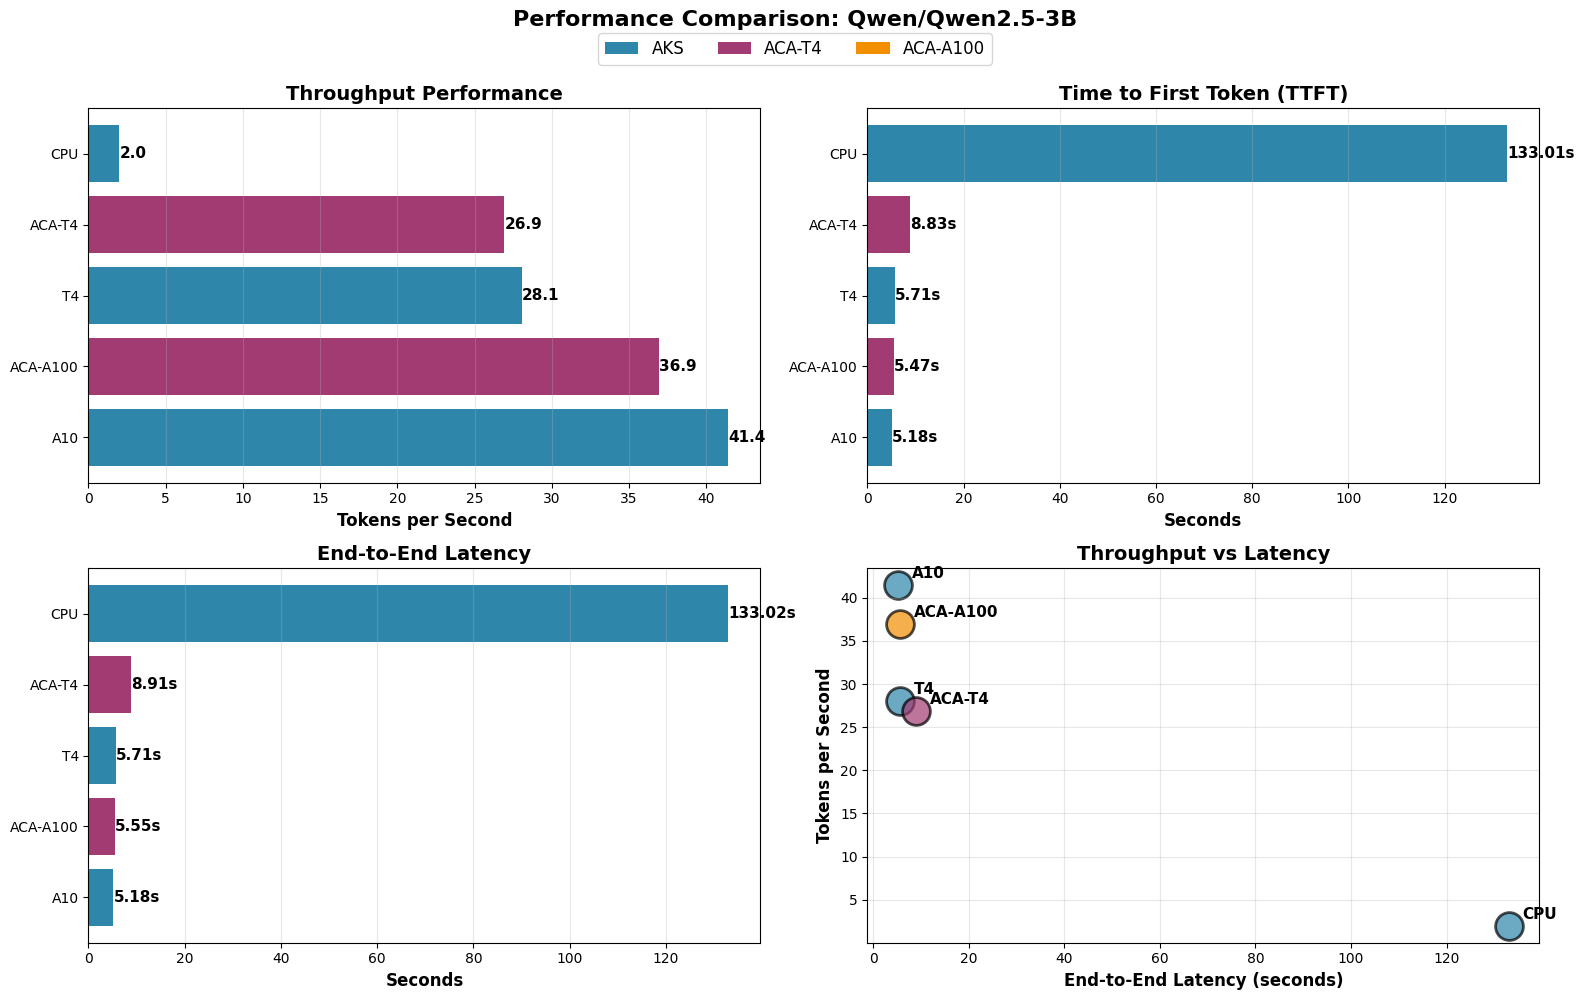


✅ Performance comparison charts generated!


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Create figure with focused performance metrics
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Colors
platforms = [d['name'] for d in comparison_data]
colors = ['#2E86AB' if d['platform'] == 'AKS' else '#A23B72' for d in comparison_data]

# 1. Tokens per Second (Throughput)
ax1 = axes[0, 0]
tps_values = [d['avg_tps'] for d in comparison_data]
bars1 = ax1.barh(platforms, tps_values, color=colors)
ax1.set_xlabel('Tokens per Second', fontsize=12, fontweight='bold')
ax1.set_title('Throughput Performance', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for bar in bars1:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.1f}', ha='left', va='center', fontsize=11, fontweight='bold')

# 2. Time to First Token
ax2 = axes[0, 1]
ttft_values = [d['avg_ttft'] for d in comparison_data]
bars2 = ax2.barh(platforms, ttft_values, color=colors)
ax2.set_xlabel('Seconds', fontsize=12, fontweight='bold')
ax2.set_title('Time to First Token (TTFT)', fontsize=14, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for bar in bars2:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}s', ha='left', va='center', fontsize=11, fontweight='bold')

# 3. End-to-End Latency
ax3 = axes[1, 0]
latency_values = [d['avg_latency'] for d in comparison_data]
bars3 = ax3.barh(platforms, latency_values, color=colors)
ax3.set_xlabel('Seconds', fontsize=12, fontweight='bold')
ax3.set_title('End-to-End Latency', fontsize=14, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

for bar in bars3:
    width = bar.get_width()
    ax3.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.2f}s', ha='left', va='center', fontsize=11, fontweight='bold')

# 4. Performance Scatter (Throughput vs Latency)
ax4 = axes[1, 1]
# Color mapping: AKS=blue, ACA-T4=purple, ACA-A100=green
color_map = {
    'AKS': '#2E86AB',
    'ACA': '#A23B72',
}
scatter_colors = []
for d in comparison_data:
    if d['platform'] == 'AKS':
        scatter_colors.append('#2E86AB')
    elif 'A100' in d['name']:
        scatter_colors.append('#F18F01')  # Orange for A100
    else:
        scatter_colors.append('#A23B72')  # Purple for T4

for i, data in enumerate(comparison_data):
    ax4.scatter(data['avg_latency'], data['avg_tps'], 
               s=400, color=scatter_colors[i], alpha=0.7, edgecolors='black', linewidth=2)
    ax4.annotate(data['name'], 
                (data['avg_latency'], data['avg_tps']),
                xytext=(10, 5), textcoords='offset points',
                fontsize=11, fontweight='bold')

ax4.set_xlabel('End-to-End Latency (seconds)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Tokens per Second', fontsize=12, fontweight='bold')
ax4.set_title('Throughput vs Latency', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3)

# Add legend with GPU types
legend_elements = [
    plt.Rectangle((0,0),1,1, fc='#2E86AB', label='AKS'),
    plt.Rectangle((0,0),1,1, fc='#A23B72', label='ACA-T4'),
    plt.Rectangle((0,0),1,1, fc='#F18F01', label='ACA-A100')
]
fig.legend(handles=legend_elements, loc='upper center', ncol=3, 
          fontsize=12, frameon=True, bbox_to_anchor=(0.5, 0.98))

plt.suptitle(f'Performance Comparison: {MODEL_NAME}', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

print("\n✅ Performance comparison charts generated!")

## Cleanup Resources

Run these cells to clean up resources when done.

In [ ]:
print("\n" + "="*70)
print("CLEANUP COMMANDS")
print("="*70)

print("\n# Delete AKS workspaces:")
for deploy_name, config in DEPLOYMENTS.items():
    if config['enabled']:
        print(f"kubectl delete workspace {config['workspace_name']}")

print("\n# Delete AKS node pools:")
for deploy_name, config in DEPLOYMENTS.items():
    if config['enabled']:
        print(f"az aks nodepool delete --resource-group {RESOURCE_GROUP} --cluster-name {CLUSTER_NAME} --name {config['nodepool_name']} --yes --no-wait")

if any(config['enabled'] for config in ACA_DEPLOYMENTS.values()):
    print(f"\n# Delete Azure Container Apps:")
    for deploy_name, config in ACA_DEPLOYMENTS.items():
        if config['enabled']:
            print(f"az containerapp delete -n {config['app_name']} -g {RESOURCE_GROUP} --yes")

print(f"\n# Delete entire resource group (WARNING: removes everything):")
print(f"az group delete --name {RESOURCE_GROUP} --yes --no-wait")

In [ ]:
# Uncomment to actually delete the resource group
# run_command(
#     f"az group delete --name {RESOURCE_GROUP} --yes --no-wait",
#     "Deleting resource group"
# )